# Initialize

In [1]:
import sqdtoolz as stz
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# from simple_pid import PID
import time

lab = stz.Laboratory(instr_config_file = r'TemperaturePID.yaml', save_dir = 'mySaves/', using_VS_Code=False)
lab.UpdateStateEnabled = False

In [2]:
lab.load_instrument('PerfectPrimeThermometer')
therm = stz.GENtherm("therm", lab, ['PerfectPrimeThermometer', 'CH1'])

c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\station.py:514: QCoDeSDeprecationWarning: The use of the "driver"-keyword in the station configuration file is deprecated. Use "the "type"-keyword instead, prepending the driver value to it" as an alternative.
  issue_deprecation_warning(
[PerfectPrimeThermometer(THERM_TC0309)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 92, in get_idn
    idstr = self.ask("*IDN?")
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 416, in ask
    raise e
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 409, in ask
    answer = self.ask_raw(cmd)
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 429, in ask_raw
    rais

In [3]:
lab.load_instrument('dc_supply')
dc_supply = stz.GENsmu('DC_SUPPLY', lab, 'dc_supply')

[dc_supply(SMU_TENMA_72_2710)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 92, in get_idn
    idstr = self.ask("*IDN?")
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 416, in ask
    raise e
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 409, in ask
    answer = self.ask_raw(cmd)
  File "c:\Users\Experiment\PythonVENVs\sqdtoolz_env\lib\site-packages\qcodes\instrument\instrument.py", line 429, in ask_raw
    raise NotImplementedError(
NotImplementedError: ('Instrument SMU_TENMA_72_2710 has not defined an ask method', "asking '*IDN?' to <SMU_TENMA_72_2710: dc_supply>")
[dc_supply(SMU_TENMA_72_2710)] Snapshot: Could not update parameter: voltage


In [7]:
dc_supply.RampRateVoltage = 10
dc_supply.RampRateCurrent = 10

In [8]:
dc_supply.Voltage = 0

In [5]:
dc_supply.Voltage, dc_supply.Current

(30.0, 0.0)

In [13]:
np.sqrt(2.7*3)

2.8460498941515415

In [4]:
dc_supply.Current = 3

In [5]:
dc_supply.Output = True

In [6]:
start = time.time()
temps = []
times = []
dc_supply.Voltage = 4
while True:
    temps += [therm.Temperature]
    times += [time.time()-start]
    time.sleep(1)

KeyboardInterrupt: 

In [28]:
dc_supply.Voltage = 0

{'amplitude': 45.86966839234924,
 'offset': 74.79999999999998,
 'decay_time': 256.6625932045736,
 'fig': <Figure size 640x480 with 1 Axes>}

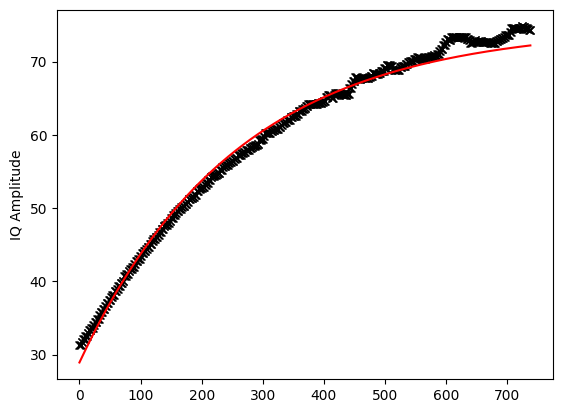

In [21]:
from sqdtoolz.Utilities.DataFitting import DFitExponential

dFit = DFitExponential()
dFit.get_fitted_plot(times, temps, rise=True)

In [41]:
dc_supply.Voltage = 0

In [40]:
import scipy.ndimage
import scipy.signal

pidK = 0.2
pidKi = 0.005
pidKd = 0.1
setPt = 100

start = time.time()
tempsCL = []
timesCL = []
dc_supply.Voltage = 4
integral = 0
while True:
    err = setPt - therm.Temperature

    integral += pidKi*err*1
    integral = np.clip(integral, 0,10)

    if len(tempsCL) == 0:
        deriv = 0
    else:
        cutoff = 0.1
        sample_rate = 1
        taps = 50
        #
        nyq_rate = sample_rate*0.5
        freq_cutoff_norm = cutoff/nyq_rate
        fir_coeffs = np.array(scipy.signal.firwin(taps, freq_cutoff_norm))
        #
        filtData = scipy.ndimage.convolve1d(tempsCL[::], fir_coeffs)

        if filtData.size <= 1:
            deriv = 0
        else:
            deriv = pidKd * (filtData[-1]-filtData[-2])

    dc_supply.Voltage = np.clip(pidK*(err) + integral + deriv, 0, 10)
    integral
    tempsCL += [therm.Temperature]
    timesCL += [time.time()-start]
    time.sleep(1)

KeyboardInterrupt: 

In [20]:
filtData.size

1

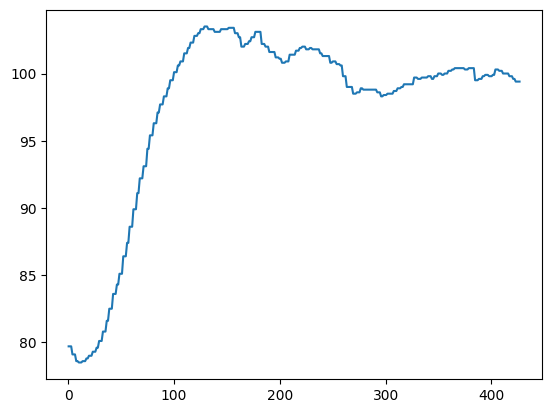

In [42]:
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal

cutoff = 0.1
sample_rate = 1
taps = 50

nyq_rate = sample_rate*0.5
freq_cutoff_norm = cutoff/nyq_rate
fir_coeffs = np.array(scipy.signal.firwin(taps, freq_cutoff_norm))

filtData = scipy.ndimage.convolve1d(tempsCL[::], fir_coeffs)

plt.plot(timesCL[::], tempsCL[::])
# plt.plot(timesCL[::], filtData)
# plt.plot(timesCL[1::], np.diff(filtData))


In [39]:
times[50*100000]

182.51529717445374

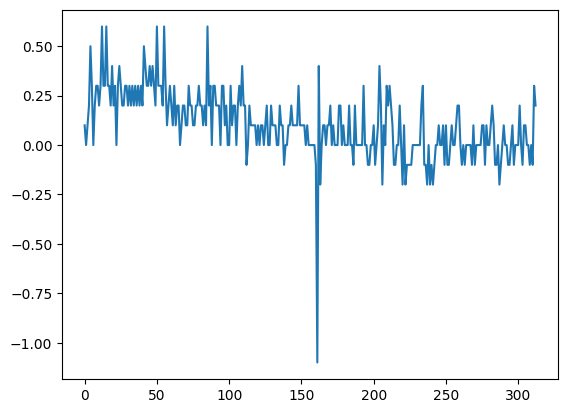

In [37]:
plt.plot(np.diff(temps[::100000]))

In [6]:
dc_supply.Current = 0
dc_supply.Voltage = 30

In [7]:
dc_supply.Output = True

In [8]:
therm.Temperature

19.6

(-20.0, 20.0)

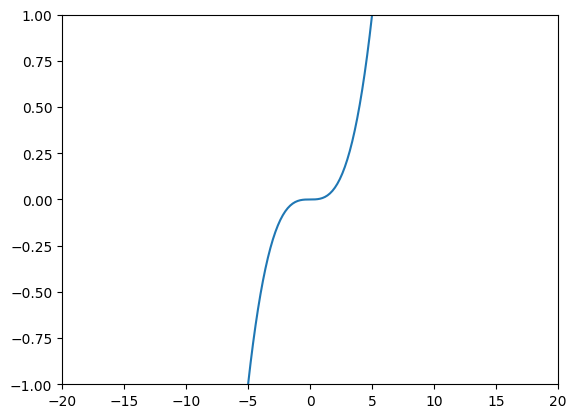

In [81]:
errors = np.linspace(-20,20, 201)
func = lambda x: ((x)/5)**3
# func = lambda x: np.piecewise(x, [x<0, x>=0], [lambda x: x**3, lambda x: (x/5)**3])
plt.plot(errors, func(errors))
plt.ylim(-1,1)
plt.xlim(-20,20)

In [28]:
#pid = PID(0.05, 0.2, 0.00, setpoint=100)
pid = PID(0.05, 0.3, 0.00, setpoint=100)
pid.output_limits = (0, 3**2)
pid.sample_time = 2/0.6 # update after 2 temperature samples
# pid.error_map = func

In [29]:
# time.sleep(5*60)

temps = []
# value to set (Temperature)
v = therm.Temperature
temps.append(v)

vs_to_set = []
while True:
    # Compute voltage to set
    v_to_set = pid(v)
    vs_to_set.append(v_to_set)
#     print(v_to_set)
    
    dc_supply.Current = v_to_set**0.5

    # value to set (Temperature)
    v = therm.Temperature
    temps.append(v)

    time.sleep(pid.sample_time)

KeyboardInterrupt: 

In [30]:
dc_supply.Current = 0

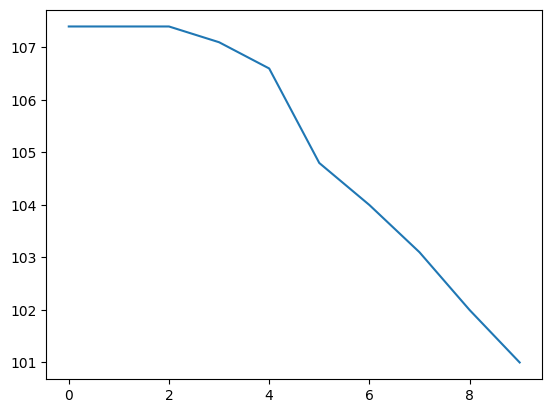

In [31]:
plt.plot(temps)
# plt.ylim(90,110)
# plt.xlim(800,850)

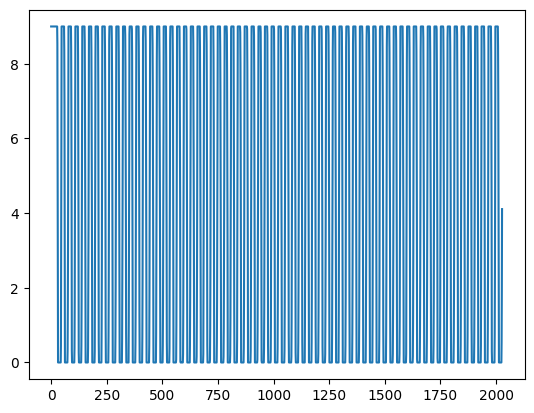

In [23]:
plt.plot(vs_to_set)